# 129L Hw 2, Problem 1

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Part a)

Spherical coordinate $\{e_r, e_\theta, e_\phi\} \rarr (1, \theta, \phi)$ <br>
Cartesian coordinate $\{x, y, z\} \rarr (sin(\theta)cos(\phi), sin(\theta)sin(\phi), cos(\theta))$ <br>
Cylindrical coordinate $\{e_\rho, e_\psi, z\} \rarr (sin(\theta), \phi, cos(\theta))$

Spherical basis: <br>
$\hat{e}_r = \sin(\theta)\cos(\phi)\hat{x} + \sin(\theta)\sin(\phi)\hat{y} + \cos(\theta)\hat{z}$ <br>
$\hat{e}_\theta = \cos(\theta)\cos(\phi)\hat{x} + \cos(\theta)\sin(\phi)\hat{y} - \sin(\theta)\hat{z}$ <br>
$\hat{e}_\phi = -\sin(\phi)\hat{x} + \cos(\phi)\hat{y}$ <br>

Cylindrical basis: <br>
$\hat{e}_\rho = \cos(\phi)\hat{x} + \sin(\phi)\hat{y}$ <br>
$\hat{e}_\psi = -\sin(\phi)\hat{x} + \cos(\phi)\hat{y}$ <br>
$\hat{z} = \hat{z}$ <br>

In [2]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r) if r != 0 else 0
    phi = np.arctan2(y, x)
    return r, theta, phi

def spherical_to_cylindrical(r, theta, phi):
    rho = r * np.sin(theta)
    psi = phi
    z = r * np.cos(theta)
    return rho, psi, z

def cylindrical_to_spherical(rho, psi, z):
    r = np.sqrt(rho**2 + z**2)
    theta = np.arctan2(rho, z) if r != 0 else 0
    phi = psi
    return r, theta, phi

def cartesian_to_cylindrical(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    return rho, psi, z

def cylindrical_to_cartesian(rho, psi, z):
    x = rho * np.cos(psi)
    y = rho * np.sin(psi)
    return x, y, z

Part b)

In [3]:
def local_orthonormal_coords(theta, phi):
    """
    Compute the local orthonormal coordinate system on the unit sphere at (theta, phi).
    """
    # Radial unit vector
    e_r = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])
    
    # Polar unit vector
    e_theta = np.array([
        np.cos(theta) * np.cos(phi),
        np.cos(theta) * np.sin(phi),
        -np.sin(theta)
    ])
    
    # Azimuthal unit vector
    e_phi = np.array([
        -np.sin(phi),
        np.cos(phi),
        0
    ])
    
    return e_r, e_theta, e_phi

In [48]:
# Generate the top half of a unit sphere
theta_vals = np.linspace(0, np.pi / 2, 10)  # Polar angles
phi_vals = np.linspace(0, 2 * np.pi, 20)   # Azimuthal angles

In [49]:
theta, phi = np.meshgrid(theta_vals, phi_vals)
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

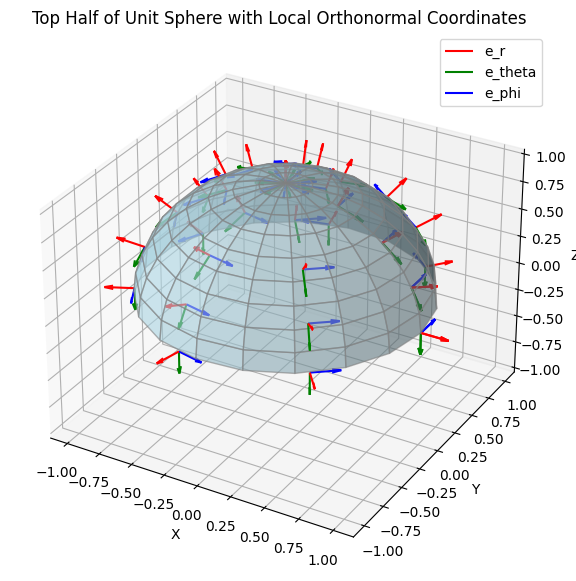

In [50]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='lightblue', alpha=0.6, edgecolor='gray')

# Select a few points on the sphere to display local coordinate systems
sample_thetas = np.linspace(0, np.pi / 2, 5)
sample_phis = np.linspace(0, 2 * np.pi, 8)

first_point = True  # To label the vectors only for the first point
for theta in sample_thetas:
    for phi in sample_phis:
        # Compute the point on the sphere
        r = np.array([
            np.sin(theta) * np.cos(phi),
            np.sin(theta) * np.sin(phi),
            np.cos(theta)
        ])
        
        # Get local orthonormal basis
        e_r, e_theta, e_phi = local_orthonormal_coords(theta, phi)
        
        # Plot the local basis vectors
        ax.quiver(*r, *e_r, color='red', length=0.2, normalize=True, label='e_r' if first_point else "")
        ax.quiver(*r, *e_theta, color='green', length=0.2, normalize=True, label='e_theta' if first_point else "")
        ax.quiver(*r, *e_phi, color='blue', length=0.2, normalize=True, label='e_phi' if first_point else "")
        first_point = False  # Disable further labeling

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlim(-1, 1)
ax.set_zlabel('Z')
ax.set_title('Top Half of Unit Sphere with Local Orthonormal Coordinates')
ax.legend(loc='upper right')
plt.show()

Part c)

No, you cannot easily plot the unit sphere in spherical basis because the basis itself is coordinate-dependent. Unlike with cartesian basis, if we move to a new point and try to plot with spherical basis, we will not have the same basis to compare to as at other parts of the sphere. 

Part d)

In [7]:
def generate_local_coords(f, x_vals, y_vals, dx=1e-4, dy=1e-4):
    Z = f(x_vals, y_vals)
    
    # Compute the gradients (∂f/∂x) and (∂f/∂y)
    fx = np.gradient(Z, axis=1, edge_order=2) / dx  # Gradient with respect to x
    fy = np.gradient(Z, axis=0, edge_order=2) / dy  # Gradient with respect to y
    
    # Tangent vectors in x and y directions
    e_x = np.array([1, 0, fx])
    e_y = np.array([0, 1, fy])
    
    # Compute the normal vector (gradient of surface)
    e_z = np.array([-fx, -fy, np.ones_like(fx)])
    
    # Normalize the normal vector
    norm_e_z = np.linalg.norm(e_z, axis=0)
    e_z = e_z / norm_e_z
    
    # Normalize the tangent vectors (optional)
    e_x = e_x / np.linalg.norm(e_x, axis=0)
    e_y = e_y / np.linalg.norm(e_y, axis=0)
    
    return e_x, e_y, e_z

Part e)

In [37]:
def parallel_transport(theta0, phi0, alpha, beta, steps=25):
    # Create theta points for the geodesic path
    theta = np.linspace(theta0, np.pi / 2, steps)
    
    # Initialize the transported vector
    n_theta = alpha
    n_phi = beta * np.sin(theta0)

    # Arrays to store vector components along the path
    n_theta_arr = []
    n_phi_arr = []

    # Perform parallel transport along the geodesic
    for t in theta:
        n_theta_arr.append(n_theta)
        n_phi_arr.append(n_phi)

        # Update the vector using the parallel transport equations
        dphi = -(n_phi / np.tan(t)) * (theta[1] - theta[0])
        n_phi += dphi

    # Compute the coordinates of the geodesic on the sphere
    x = np.sin(theta) * np.cos(phi0)
    y = np.sin(theta) * np.sin(phi0)
    z = np.cos(theta)

    # Compute vector components in 3D space
    vec_x = np.sin(theta) * np.cos(phi0) * np.array(n_theta_arr)
    vec_y = np.sin(theta) * np.sin(phi0) * np.array(n_theta_arr)
    vec_z = np.cos(theta) * np.array(n_theta_arr)

    return x, y, z, vec_x, vec_y, vec_z

In [19]:
# Initial conditions
alpha = 1.0   # Component along e_theta
beta = 0.0    # Component along e_phi
theta0 = np.pi / 5  # Initial polar angle
phi0 = 0.0  # Initial azimuthal angle

# Perform parallel transport
x, y, z, vec_x, vec_y, vec_z = parallel_transport(theta0, phi0, alpha, beta)

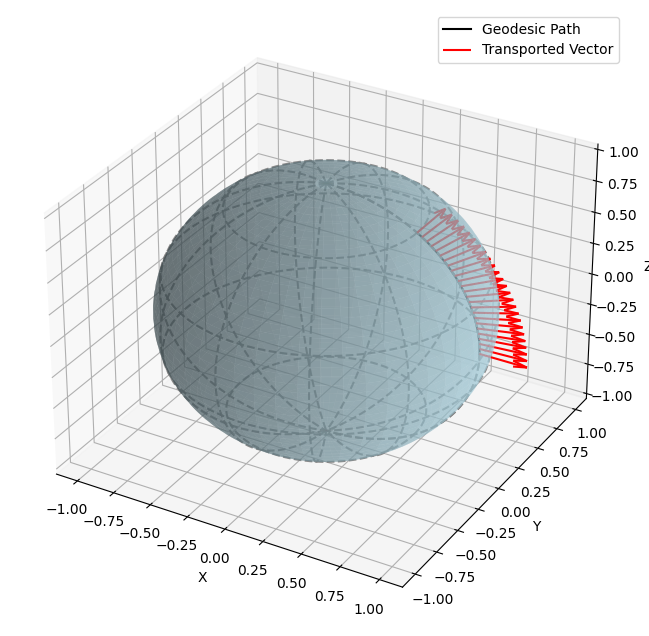

In [30]:
# Plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.sin(v), np.cos(u))
y_sphere = np.outer(np.sin(v), np.sin(u))
z_sphere = np.outer(np.cos(v), np.ones_like(u))
ax.plot_surface(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.5)

# Plot the geodesic path
ax.plot(x, y, z, color='black', label='Geodesic Path')

# Plot the transported vector along the path
ax.quiver(x, y, z, vec_x, vec_y, vec_z, color='red', label='Transported Vector', length=0.3)

# Plot latitude lines (constant theta, vary phi)
for lat in np.linspace(-np.pi / 2, np.pi / 2, 6):  # Choose 6 latitudes
    x_lat = np.cos(np.linspace(0, 2 * np.pi, 100)) * np.cos(lat)
    y_lat = np.sin(np.linspace(0, 2 * np.pi, 100)) * np.cos(lat)
    z_lat = np.ones(100) * np.sin(lat)
    ax.plot(x_lat, y_lat, z_lat, color="gray", linestyle="--", alpha=0.9)

# Plot longitude lines (constant phi, vary theta)
for lon in np.linspace(0, 2 * np.pi, 12):  # Choose 12 longitudes
    x_lon = np.sin(np.linspace(0, np.pi, 100)) * np.cos(lon)
    y_lon = np.sin(np.linspace(0, np.pi, 100)) * np.sin(lon)
    z_lon = np.cos(np.linspace(0, np.pi, 100))
    ax.plot(x_lon, y_lon, z_lon, color="gray", linestyle="--", alpha=0.9)

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

Part f)

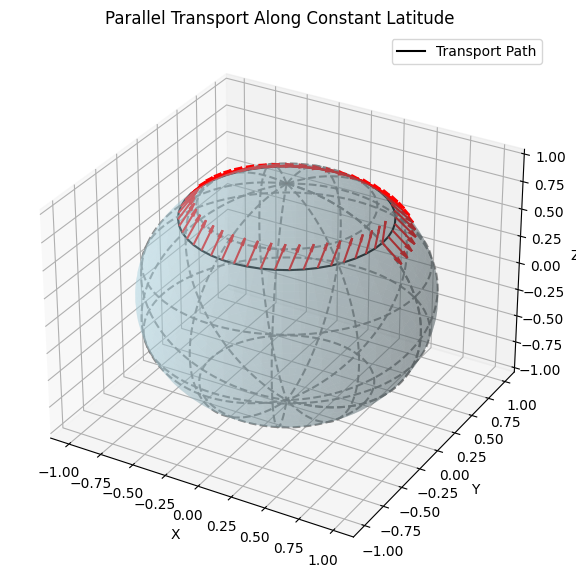

In [40]:
# Define parameters
theta0 = np.pi / 4  # Constant latitude (45 degrees)
alpha = 1.0         # Initial e_theta component
beta = 0.0          # Initial e_phi component
phi_start = 0       # Starting longitude
phi_end = 2 * np.pi # Ending longitude

# Define the parallel transport equations
def parallel_transport(phi, n):
    n_theta, n_phi = n
    dn_theta_dphi = np.arctan(theta0) * n_phi
    dn_phi_dphi = -np.arctan(theta0) * n_theta
    return [dn_theta_dphi, dn_phi_dphi]

# Solve the ODEs
phi_values = np.linspace(phi_start, phi_end, 50)
solution = solve_ivp(parallel_transport, [phi_start, phi_end], [alpha, beta], t_eval=phi_values)
n_theta_vals, n_phi_vals = solution.y

# Convert to Cartesian coordinates for plotting
x_vals, y_vals, z_vals = [], [], []
vec_x_vals, vec_y_vals, vec_z_vals = [], [], []

for i, phi in enumerate(phi_values):
    # Spherical to Cartesian
    x = np.sin(theta0) * np.cos(phi)
    y = np.sin(theta0) * np.sin(phi)
    z = np.cos(theta0)
    x_vals.append(x)
    y_vals.append(y)
    z_vals.append(z)

    # Vector components in Cartesian coordinates
    n_theta = n_theta_vals[i]
    n_phi = n_phi_vals[i]
    vec_x = n_theta * np.cos(theta0) * np.cos(phi) - n_phi * np.sin(phi)
    vec_y = n_theta * np.cos(theta0) * np.sin(phi) + n_phi * np.cos(phi)
    vec_z = -n_theta * np.sin(theta0)
    vec_x_vals.append(vec_x)
    vec_y_vals.append(vec_y)
    vec_z_vals.append(vec_z)

# Plot the sphere and the transported vector
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='lightblue', alpha=0.3)

# Plot the geodesic (latitude line)
ax.plot(x_vals, y_vals, z_vals, color='k', label='Transport Path')

# Plot the transported vector
ax.quiver(x_vals, y_vals, z_vals, vec_x_vals, vec_y_vals, vec_z_vals, color='red', length=0.2, normalize=True)

# Plot latitude lines (constant theta, vary phi)
for lat in np.linspace(-np.pi / 2, np.pi / 2, 6):  # Choose 6 latitudes
    x_lat = np.cos(np.linspace(0, 2 * np.pi, 100)) * np.cos(lat)
    y_lat = np.sin(np.linspace(0, 2 * np.pi, 100)) * np.cos(lat)
    z_lat = np.ones(100) * np.sin(lat)
    ax.plot(x_lat, y_lat, z_lat, color="gray", linestyle="--", alpha=0.9)

# Plot longitude lines (constant phi, vary theta)
for lon in np.linspace(0, 2 * np.pi, 12):  # Choose 12 longitudes
    x_lon = np.sin(np.linspace(0, np.pi, 100)) * np.cos(lon)
    y_lon = np.sin(np.linspace(0, np.pi, 100)) * np.sin(lon)
    z_lon = np.cos(np.linspace(0, np.pi, 100))
    ax.plot(x_lon, y_lon, z_lon, color="gray", linestyle="--", alpha=0.9)

# Add labels and show
ax.set_title("Parallel Transport Along Constant Latitude")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

Part g)

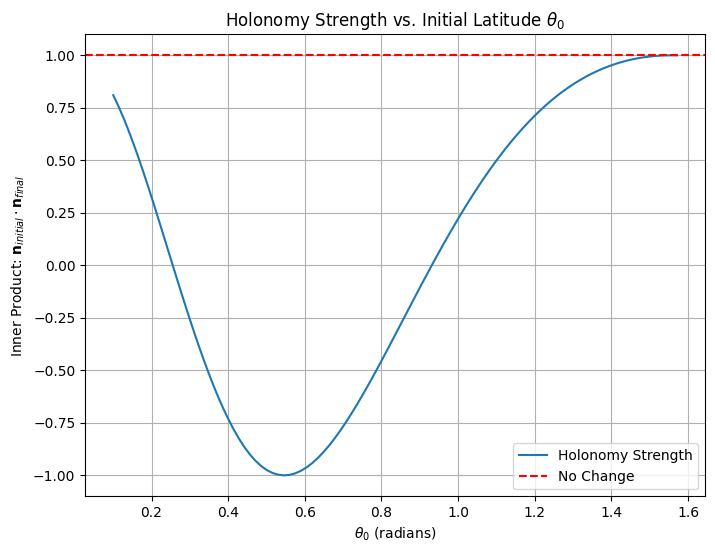

In [45]:
# Define parallel transport equations along constant θ0
def parallel_transport_phi(phi, n, theta0):
    n_theta, n_phi = n
    dn_theta_dphi = np.arctan(theta0) * n_phi
    dn_phi_dphi = -np.arctan(theta0) * n_theta
    return [dn_theta_dphi, dn_phi_dphi]

# Initial conditions and θ0 range
theta0_values = np.linspace(0.1, np.pi / 2, 100)  # Avoid θ0=0 to prevent division by zero
alpha, beta = 1.0, 0.0  # Initial vector in (e_theta, e_phi) components
holonomy_strength = []

for theta0 in theta0_values:
    # Solve parallel transport equations for one loop (φ: 0 → 2π)
    sol = solve_ivp(
        parallel_transport_phi, [0, 2 * np.pi], [alpha, beta],
        args=(theta0,), t_eval=[2 * np.pi]
    )
    n_final = sol.y[:, -1]  # Final vector after transport
    
    # Compute the inner product between initial and final vectors
    n_initial = np.array([alpha, beta])
    dot_product = np.dot(n_initial, n_final)
    holonomy_strength.append(dot_product)

# Plot holonomy strength as a function of θ0
plt.figure(figsize=(8, 6))
plt.plot(theta0_values, holonomy_strength, label="Holonomy Strength")
plt.axhline(1, color='red', linestyle='--', label="No Change")
plt.xlabel(r"$\theta_0$ (radians)")
plt.ylabel("Inner Product: $\mathbf{n}_{initial} \cdot \mathbf{n}_{final}$")
plt.title("Holonomy Strength vs. Initial Latitude $\\theta_0$")
plt.legend()
plt.grid()
plt.show()